In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.size'] = 13

# The unit system for the calculation

Unit system can be constructed by setting units of the following dimensions:

- The unit of velocity $v_{0} = c$
- The unit of Coulomb constant $k_{e0} = k_{e} \equiv \frac{1}{4\pi\varepsilon_{0}}$
- The unit of charge $q_{0} = e$, i.e. the elementary charge
- The unit of length $l_{0} = 1cm$, a typical length scale of an undulator period, denoted as $\lambda_{u}$

Then, units of other dimensions can be derived as the following, among others:

- The unit of time $t_{0} = l_{0} / v_{0}$
- The unit of mass $m_{0} = k_{e0} q_{0}^2 t_{0}^2 l_{0}^{-3}$

In [2]:
c_si = 299792458  # in meters per second
ke_si = 8.9875517923
e_si = 1.60217662e-19  # in Coulomb

v0_si = c_si
ke0_si = ke_si
q0_si = e_si
l0_si = 0.01  # in meters

In [3]:
t0_si = l0_si / v0_si

mass_0_si = ke0_si * q0_si**2 * t0_si**2 * l0_si**(-3)

energy_0_si = mass_0_si * l0_si * t0_si**(-2)

Efield_0_si = mass_0_si * l0_si * t0_si**(-2) * q0_si**(-1)

scalar_pot_0_si = energy_0_si / q0_si
# scalar_pot_0_femtojoule_per_coulomb = scalar_pot_0_si * 1e15

t0_ps = t0_si * 1e12
print("t0 = {:.2f} ps".format(t0_ps))

t0 = 33.36 ps


In [35]:
1./(1-vxs**2)**0.5

1.25

# For motion in 2D Cartesian coordinates

#### Construct a spatial grid

In [4]:
x_arr = np.linspace(-2,10,131)
y_arr = np.linspace(-5,5,91)

x_mesh, y_mesh = np.meshgrid(x_arr, y_arr, indexing='ij')

mesh_shape = x_mesh.shape

spatial_dimenion = 2
vec_mesh_shape = mesh_shape + (spatial_dimenion,)

#### Set the motion of an electron under the influence of an undulator

In [5]:
from numpy import sin, cos, pi

q = -1

vxs = 0.6
def xs_f(t): return vxs * t
def vxs_f(t): return vxs * np.ones_like(t)
def vdotxs_f(t): return np.zeros_like(t)

lambda_u = 1. # the period of an undulator in consideration, in unit of 1cm
omega_u = 2.* pi * vxs / lambda_u
y0 = 0.1 # possibly proportional to the magnetic field
def ys_f(t): return (t <= 0.) * y0 + (t > 0.) * y0 * cos(omega_u*t)
def vys_f(t): return (t <= 0.) * 0. + (t > 0.) * (- y0 * omega_u) * sin(omega_u*t)
def vdotys_f(t): return (t <= 0.) * 0. + (t > 0.) * (- y0 * omega_u * omega_u) * cos(omega_u*t)

#### Set a temporal grid

In [6]:
t_arr = np.linspace(-3, 10, 51)

#### Check whether the speed of electron does not exceed the speed of light

In [7]:
velocity_max = (vxs**2 + (y0*omega_u)**2)**0.5
print("Maximum magnitude of velocity : {}".format(velocity_max))

Maximum magnitude of velocity : 0.7086058872008381


In [8]:
vxs * 2*np.pi / omega_u * 2./3.

0.6666666666666666

In [9]:
lorentz_factor_vxs = 1./(1-(vxs)**2)**0.5
lorentz_factor_vxs

1.25

In [10]:
lambda_fundamental_radiation = lambda_u * ((1 - vxs) / vxs)
lambda_fundamental_radiation

0.6666666666666667

In [11]:
v_abs_t_arr = np.sqrt(vxs_f(t_arr)**2 + vys_f(t_arr)**2)
assert np.all(v_abs_t_arr < 1.)  # 1 is the speed of light
v_abs_t_arr.max()

0.7085900517947191

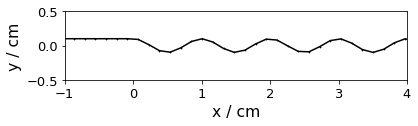

In [12]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(xs_f(t_arr), ys_f(t_arr), '.-', markersize=1.5, color='black')
ax.set_aspect('equal')
# ax.set_xlim(x_arr[[0,-1]]), ax.set_ylim(y_arr[[0,-1]])
ax.set_xlim(-1,4), ax.set_ylim(-0.5,0.5)
ax.set_xlabel("x / cm", fontsize='large')
ax.set_ylabel(r"y / cm", fontsize='large')
fig.tight_layout()
# fig.savefig("electron-trajectory-test-1.png")

In [13]:
from numpy import sqrt
def retarded_time_eq(tau, t, x, y, xs, ys):
    return sqrt((x-xs(t-tau))**2 + (y - ys(t-tau))**2)

In [14]:
from scipy.optimize import fixed_point

phi_mesh_stack = np.empty((t_arr.size,)+mesh_shape)

E_vec_mesh_stack = np.empty((t_arr.size,) + vec_mesh_shape)

tau_mesh = np.empty(mesh_shape)
tr_mesh = np.empty(mesh_shape)
R_vec_mesh = np.empty(vec_mesh_shape)
R_mesh = np.empty(mesh_shape)
vs_vec_mesh = np.empty(vec_mesh_shape)
R_vec_minus_R_vs_vec = np.empty(vec_mesh_shape)
vdots_vec_mesh = np.empty(vec_mesh_shape)

for t_index in range(t_arr.size):

    for i, j in np.ndindex(*tau_mesh.shape):
        try:
            tau_mesh[i,j] = fixed_point(retarded_time_eq, x0=0., 
                                        args=(t_arr[t_index], x_arr[i], y_arr[j], xs_f, ys_f), maxiter=500)
        except:
            print(i,j,x_arr[i],y_arr[i],t_index,t_arr[t_index])
            break

    tr_mesh[:] = t_arr[t_index] - tau_mesh

    xs_tr_mesh = xs_f(tr_mesh)
    ys_tr_mesh = ys_f(tr_mesh)

    R_vec_mesh[...,0] = x_mesh - xs_tr_mesh
    R_vec_mesh[...,1] = y_mesh - ys_tr_mesh

    R_mesh[:] = np.linalg.norm(R_vec_mesh, axis=-1)
    # R_mesh = sqrt((x_mesh - xs_tr_mesh)**2 + (y_mesh - ys_tr_mesh)**2)

    vs_vec_mesh[...,0] = vxs_f(tr_mesh)
    vs_vec_mesh[...,1] = vys_f(tr_mesh)

    R_dot_v_mesh = np.sum(R_vec_mesh * vs_vec_mesh, axis=-1)

    temp_mesh = R_mesh - R_dot_v_mesh
    temp_mesh[temp_mesh==0] = temp_mesh[temp_mesh!=0].min()
    R_minus_R_dot_v_mesh_regulated = temp_mesh
    
    phi_mesh_stack[t_index] = q * 1./ R_minus_R_dot_v_mesh_regulated
    
    ############## Electric field
    
    R_vec_minus_R_vs_vec[...,0] = R_vec_mesh[...,0] - R_mesh * vs_vec_mesh[...,0]
    R_vec_minus_R_vs_vec[...,1] = R_vec_mesh[...,1] - R_mesh * vs_vec_mesh[...,1]
    
    vs_mesh = np.linalg.norm(vs_vec_mesh, axis=-1)
    
    vdots_vec_mesh[...,0] = vdotxs_f(tr_mesh)
    vdots_vec_mesh[...,1] = vdotys_f(tr_mesh)
    
    first_cross = np.cross(R_vec_minus_R_vs_vec, vdots_vec_mesh)
    
    E_vec_mesh_stack[t_index,...,0] = q * (1 - vs_mesh**2) * R_vec_minus_R_vs_vec[...,0] / R_minus_R_dot_v_mesh_regulated**3 \
        + R_vec_mesh[...,1] * first_cross / R_minus_R_dot_v_mesh_regulated**3
    
    E_vec_mesh_stack[t_index,...,1] = q * (1 - vs_mesh**2) * R_vec_minus_R_vs_vec[...,1] / R_minus_R_dot_v_mesh_regulated**3 \
        - R_vec_mesh[...,0] * first_cross / R_minus_R_dot_v_mesh_regulated**3

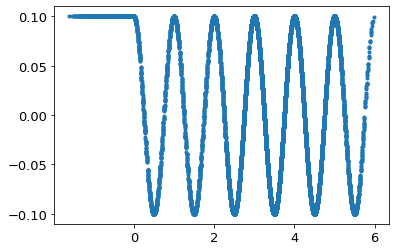

In [15]:
fig, ax = plt.subplots()

ax.plot(xs_tr_mesh.ravel(), ys_tr_mesh.ravel(), '.')

#### Visualize the scalar potential $\Phi(\mathbf{x},t)$

In [16]:
phi_si_mesh_stack = phi_mesh_stack * scalar_pot_0_si

In [18]:
%matplotlib notebook

from matplotlib.colors import LogNorm, Normalize

In [19]:
"{:.2e} J/C".format(scalar_pot_0_si)

'1.44e-14 J/C'

<IPython.core.display.Javascript object>


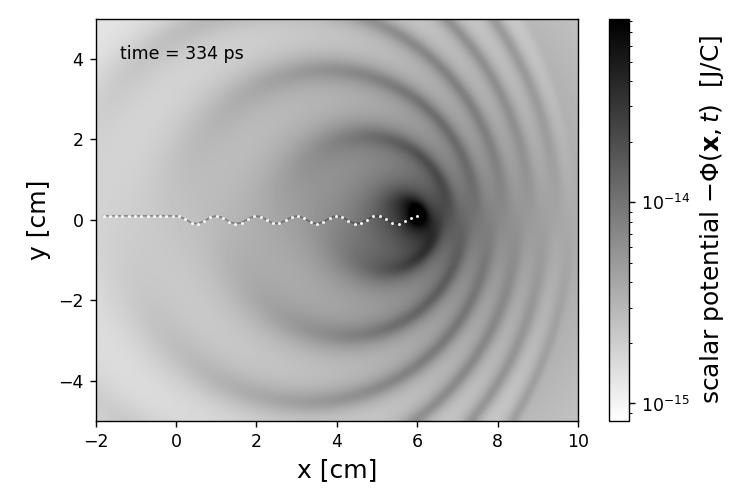

In [24]:
fig, ax = plt.subplots(figsize=(6,4))

t_index = 0

C_stack = - phi_si_mesh_stack

C_lower_val, C_upper_val = np.quantile(C_stack, [0, 0.999]) 

interp_method = 'bicubic'
# interp_method = 'none'
img = ax.imshow(C_stack[t_index].transpose(), extent=(*x_arr[[0,-1]], *y_arr[[0,-1]]), 
                aspect='equal', origin='lower', norm=LogNorm(C_upper_val * 1e-2, C_upper_val), 
                cmap='binary', interpolation=interp_method)
cb = fig.colorbar(img, ax=ax)

# ax.plot(xs_f(t_arr[t_index]), ys_f(t_arr[t_index]), 'x', color='white')
lpoints, = ax.plot(xs_f(t_arr[:t_index+1]), ys_f(t_arr[:t_index+1]), '.-', 
                   color=(0,0,0,0.3), markersize=1.5, markerfacecolor=(1,1,1,0.9), markeredgecolor=(1,1,1,0.9), linewidth=1)

cb.set_label(r"scalar potential $-\Phi(\mathbf{x},t)$  [J/C]", fontsize='x-large')
ax.set_xlabel("x [cm]", fontsize='x-large')
ax.set_ylabel(r"y [cm]", fontsize='x-large')
fig.tight_layout()


text_time = ax.text(0.05, 0.9, '', transform=ax.transAxes)
text_error = ax.text(0.5, 0.5, '', transform=ax.transAxes)

# img.set_data(phi_mesh_stack[2].transpose())


def update(t_index):
    try:
        img.set_data(C_stack[t_index].transpose())
    except Exception as e:
        text_error.set_text("Error : '{:s}'".format(e))
    text_time.set_text("time = {:.0f} ps".format(t_arr[t_index] * t0_ps))
    lpoints.set_data(xs_f(t_arr[:t_index+1]), ys_f(t_arr[:t_index+1]))


from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, update, frames=t_arr.size)


# fig.savefig("xy-scalar-potential-test-2.png")

In [25]:
from matplotlib.animation import FFMpegWriter, FFMpegFileWriter

# from matplotlib.animation import PillowWriter

# from matplotlib.animation import ImageMagickWriter

# writer = FFMpegWriter()
writer = FFMpegFileWriter()
# writer = PillowWriter(bitrate=900)
# writer = ImageMagickWriter()

In [26]:
# ani.save("scalar-pot-smooth-cosine-test-11-interp-{}.mp4".format(interp_method), writer=writer)

#### Visualize the electric field

In [27]:
E_mesh_stack = np.linalg.norm(E_vec_mesh_stack, axis=-1)

E_si_mesh_stack = E_mesh_stack * Efield_0_si

<IPython.core.display.Javascript object>


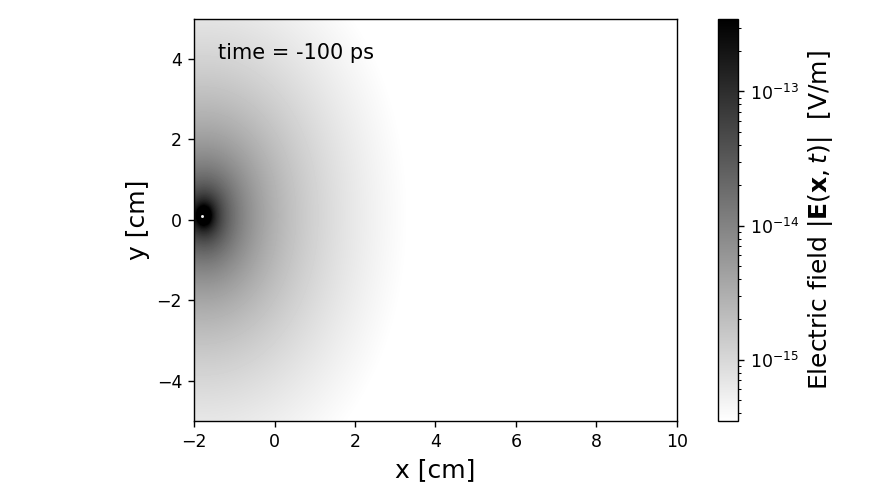

In [34]:
fig, ax = plt.subplots(figsize=(7,4))

t_index = 0

C_stack = E_si_mesh_stack
C_lower_val, C_upper_val = np.quantile(C_stack, [0, 0.999])

interp_method = 'bicubic'
# interp_method = 'none'
img = ax.imshow(C_stack[t_index].transpose(), extent=(*x_arr[[0,-1]], *y_arr[[0,-1]]), 
                aspect='equal', origin='lower', norm=LogNorm(C_upper_val * 1e-3, C_upper_val), 
                cmap='binary', interpolation=interp_method)
cb = fig.colorbar(img, ax=ax)

# ax.plot(xs_f(t_arr[t_index]), ys_f(t_arr[t_index]), 'x', color='white')
lpoints, = ax.plot(xs_f(t_arr[:t_index+1]), ys_f(t_arr[:t_index+1]), '.-', 
                   color=(0,0,0,0.3), markersize=1.5, markerfacecolor=(1,1,1,0.9), markeredgecolor=(1,1,1,0.9), linewidth=1)

cb.set_label(r"Electric field $|\mathbf{E}(\mathbf{x},t)|$  [V/m]", fontsize='x-large')
ax.set_xlabel("x [cm]", fontsize='x-large')
ax.set_ylabel(r"y [cm]", fontsize='x-large')
fig.tight_layout()


text_time = ax.text(0.05, 0.9, '', transform=ax.transAxes, fontsize='large')
text_error = ax.text(0.5, 0.5, '', transform=ax.transAxes)

# img.set_data(phi_mesh_stack[2].transpose())


def update(t_index):
    try:
        img.set_data(C_stack[t_index].transpose())
    except Exception as e:
        text_error.set_text("Error : '{:s}'".format(e))
    text_time.set_text("time = {:.0f} ps".format(t_arr[t_index] * t0_ps))
    lpoints.set_data(xs_f(t_arr[:t_index+1]), ys_f(t_arr[:t_index+1]))


from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, update, frames=t_arr.size)

In [32]:
# ani.save("electric-field-actual-smooth-cosine-test-14-interp-{}.mp4".format(interp_method), writer=writer)

# For a linear motion

In [ ]:
v0 = 0.1
def z_s(t):
    return v0 * t
def z_dot_s(t):
    return v0 * np.ones_like(t)

In [ ]:
rho_arr = np.linspace(0,1,11)
z_arr = np.linspace(-1,1,21)

rho_mesh, z_mesh = np.meshgrid(rho_arr, z_arr, indexing='ij')

In [ ]:
from numpy import sqrt
def retarded_time_eq(tau, t, rho, z, z_s):
    return sqrt(rho**2 + (z - z_s(t-tau))**2)

In [ ]:
t_arr = np.linspace(0, 5, 11)
t_index = -1

In [ ]:
z_s(t_arr[t_index])

In [ ]:
from scipy.optimize import fixed_point

tau_mesh = np.empty((rho_arr.size, z_arr.size))
for i, j in np.ndindex(rho_arr.size, z_arr.size):
    tau_mesh[i,j] = fixed_point(retarded_time_eq, x0=0., args=(t_arr[t_index], rho_arr[i], z_arr[j], z_s))

In [ ]:
tr_mesh = t_arr[t_index] - tau_mesh

In [ ]:
R_mesh = sqrt(rho_mesh**2 + (z_mesh - z_s(tr_mesh))**2)

In [ ]:
R_mesh_regulated = R_mesh.copy()
R_mesh_regulated[R_mesh == 0] = np.min(R_mesh[R_mesh!=0])

In [ ]:
one_over_R_mesh = 1./ R_mesh_regulated

In [ ]:
R_dot_v_mesh = (z_mesh - z_s(tr_mesh)) * z_dot_s(tr_mesh)

In [ ]:
temp_mesh = R_mesh - R_dot_v_mesh
temp_mesh[temp_mesh==0] = temp_mesh[temp_mesh!=0].min()
phi_mesh = 1./temp_mesh

# phi_mesh = one_over_R_mesh

In [ ]:
phi_lower_val, phi_upper_val = np.quantile(phi_mesh, [0.01, 0.99]) 
# phi_mesh

phi_lower_val, phi_upper_val

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))
img = ax.imshow(phi_mesh, extent=(*z_arr[[0,-1]], *rho_arr[[0,-1]]), 
                aspect='equal', origin='lower', vmin=phi_lower_val, vmax=phi_upper_val, cmap='binary')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r"scalar potential $\Phi$", fontsize='large')
ax.set_xlabel("z / $x_{0}$", fontsize='x-large')
ax.set_ylabel(r"$\rho$ / $x_{0}$", fontsize='x-large')
fig.tight_layout()
# fig.savefig("scalar-potential-test-2.png")

# For a generic movement in 3D

In [ ]:
from numpy import asarray
def r_s(t):
    _t = asarray(t)
    _shape = (3,)
    if _t.ndim > 0: _shape = _t.shape + _shape
    
    _r_s = np.empty(_shape, dtype=float)
    _r_s[...,0] = 0.
    _r_s[...,1] = 0.
    _r_s[...,2] = 0.
    
    return _r_s